# Project 0 Report

In this project report, I analyze how different workload types immediate, const(10), const(50) affect throughput and latency in both closed-loop and open-loop client models. We measure these metrics from the client side and compare median, 95th, and 99th percentile latencies. 

This project investigates these tradeoffs by implementing closed-loop and open-loop workload generators. Each generator issues requests specifying different server-side workloads:
- Immediate (0 processing time)
- Const(10) constant 10ms overhead
- Const(50) constant 50ms overhead

We also uses the insights from flame graphs and perf profiling to identify the exact sections of the code that cause bottlenecks.

## Closed Loop

### Throughput-Latency Graphs

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

data_dir = "../data"

#### Closed Loop Median

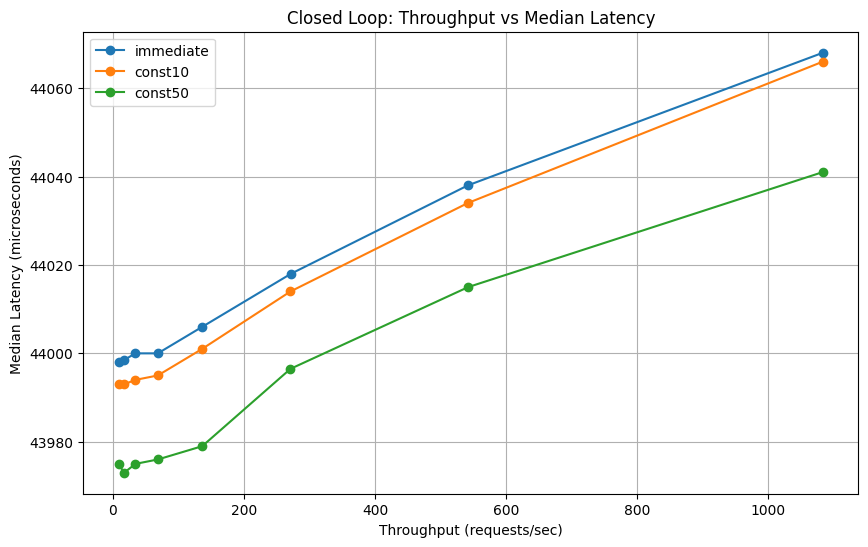

In [27]:
# Load the data
df_path = f"{data_dir}/closed_loop_summary.csv"
df = pd.read_csv(df_path)

# df columns:
# throughput,median_latency,p95_latency,p99_latency,workload,threads
# plot the data for each workload type as separate lines

# plot the throughput-latency graph for all median latencies
# x-axis is the offered load
# y-axis is the latency
throughput = [] # packet per second
latency = [] # microseconds

plt.figure(figsize=(10, 6))

for workload in df['workload'].unique():
    workload_data = df[df['workload'] == workload]
    plt.plot(workload_data['throughput'], workload_data['median_latency'], 
             marker='o', label=workload)

plt.xlabel('Throughput (requests/sec)')
plt.ylabel('Median Latency (microseconds)')
plt.title('Closed Loop: Throughput vs Median Latency')
plt.legend()
plt.grid(True)
#plt.yscale('log')
#plt.xscale('log')
plt.show()


#### Closed Loop P95

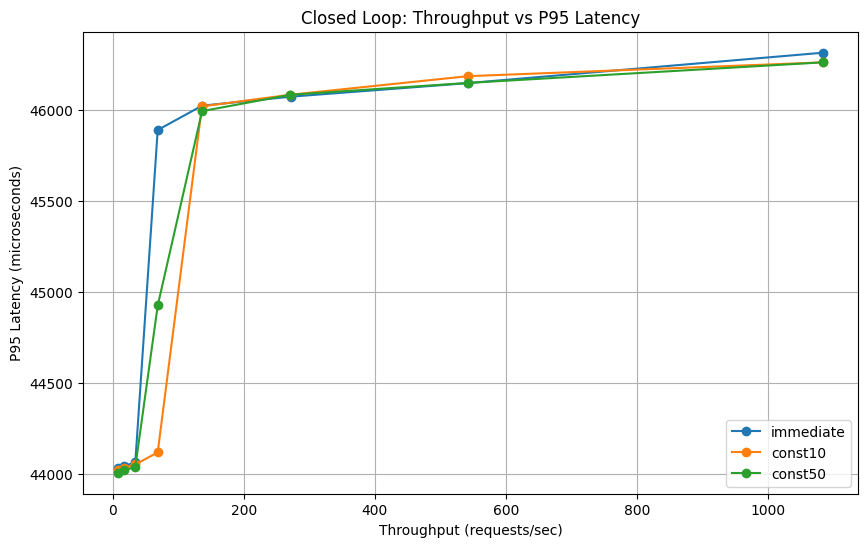

In [28]:
# plot the throughput-latency graph for all p95 latencies
plt.figure(figsize=(10, 6))

for workload in df['workload'].unique():
    workload_data = df[df['workload'] == workload]
    plt.plot(workload_data['throughput'], workload_data['p95_latency'], 
             marker='o', label=workload)

plt.xlabel('Throughput (requests/sec)')
plt.ylabel('P95 Latency (microseconds)')
plt.title('Closed Loop: Throughput vs P95 Latency')
plt.legend()
plt.grid(True)
#plt.yscale('log')
#plt.xscale('log')
plt.show()


#### Closed Loop P99

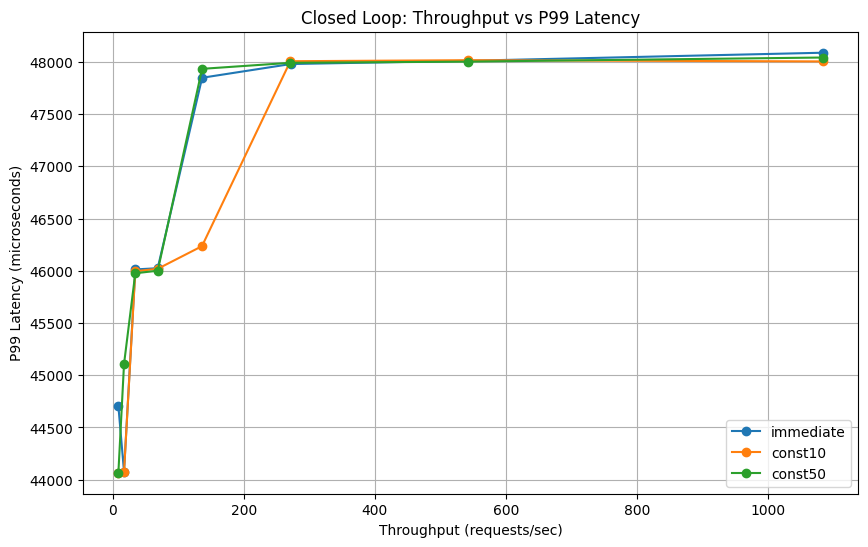

In [30]:
# plot the throughput-latency graph for all p99 latencies
plt.figure(figsize=(10, 6))

for workload in df['workload'].unique():
    workload_data = df[df['workload'] == workload]
    plt.plot(workload_data['throughput'], workload_data['p99_latency'], 
             marker='o', label=workload)

plt.xlabel('Throughput (requests/sec)')
plt.ylabel('P99 Latency (microseconds)')
plt.title('Closed Loop: Throughput vs P99 Latency')
plt.legend()
plt.grid(True)
#plt.yscale('log')
#plt.xscale('log')
plt.show()


## Analysis:

Describe the graphs above. Why do they exhibit this pattern?

For the closed loop generator, we observer
1. Stable median latency for all throughput point

2. Gradual increase in P95 and P99 latencies

The reason for this pattern could be the self-throtting mechanism of the closed loop system, each clinet waits for a response before sending the next request. If the server becomes heavily loaded, the client request rate is consequently decreased. Becuase the client cannot exceed the rate at which the server processes requests, the latency growth is bounded.

## Open Loop

### Throughput-Latency Graphs

#### Open Loop Median

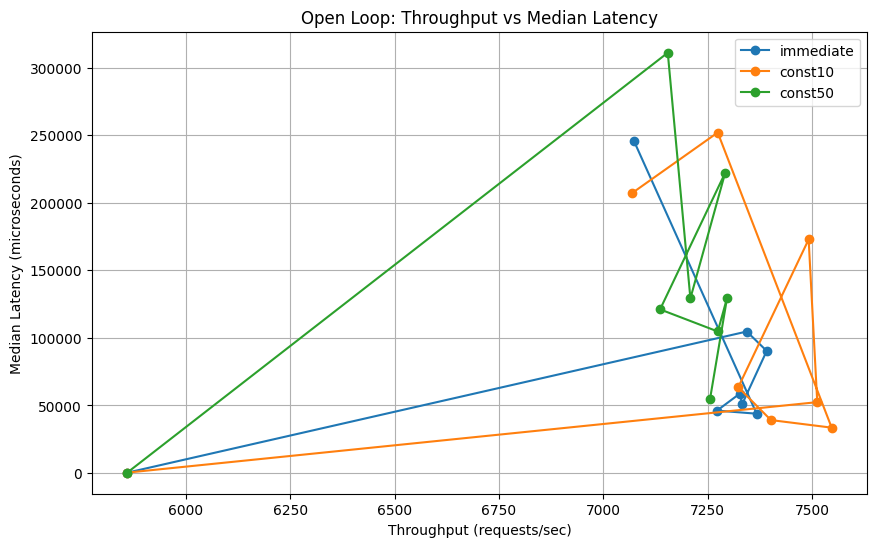

In [31]:
# Read the open loop data
df_open = pd.read_csv('../data/open_loop_summary.csv')

# plot the throughput-latency graph for all median latencies
plt.figure(figsize=(10, 6))

for workload in df_open['workload'].unique():
    workload_data = df_open[df_open['workload'] == workload]
    plt.plot(workload_data['throughput'], workload_data['median_latency'], 
             marker='o', label=workload)

plt.xlabel('Throughput (requests/sec)')
plt.ylabel('Median Latency (microseconds)')
plt.title('Open Loop: Throughput vs Median Latency')
plt.legend()
plt.grid(True)
# plt.yscale('log')
# plt.xscale('log')
plt.show()


#### Open Loop P95

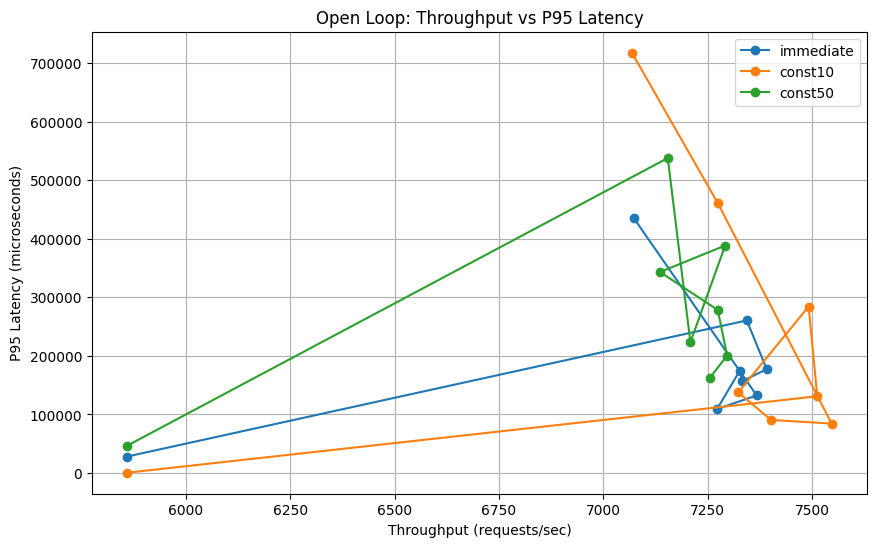

In [32]:
# plot the throughput-latency graph for all p95 latencies
plt.figure(figsize=(10, 6))

for workload in df_open['workload'].unique():
    workload_data = df_open[df_open['workload'] == workload]
    plt.plot(workload_data['throughput'], workload_data['p95_latency'], 
             marker='o', label=workload)

plt.xlabel('Throughput (requests/sec)')
plt.ylabel('P95 Latency (microseconds)')
plt.title('Open Loop: Throughput vs P95 Latency')
plt.legend()
plt.grid(True)
# plt.yscale('log')
# plt.xscale('log')
plt.show()


#### Open Loop P99

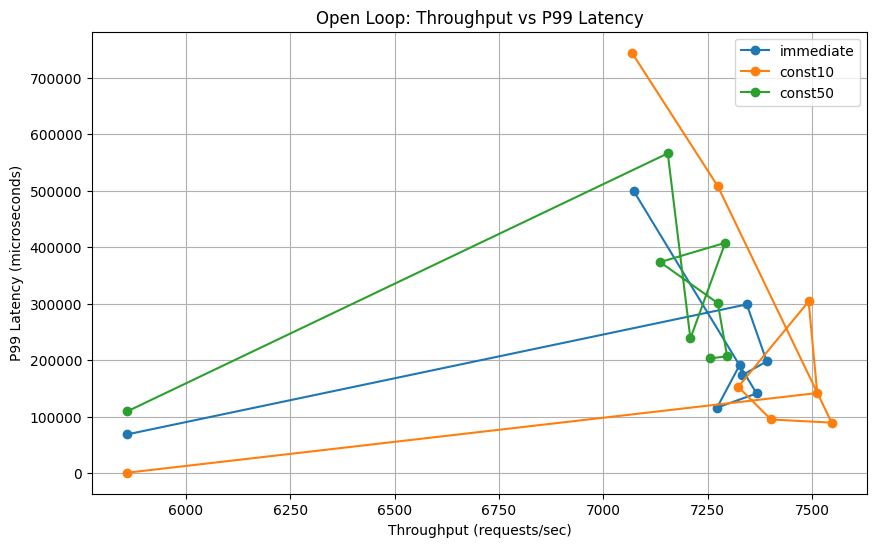

In [33]:
# plot the throughput-latency graph for all p99 latencies
plt.figure(figsize=(10, 6))

for workload in df_open['workload'].unique():
    workload_data = df_open[df_open['workload'] == workload]
    plt.plot(workload_data['throughput'], workload_data['p99_latency'], 
             marker='o', label=workload)

plt.xlabel('Throughput (requests/sec)')
plt.ylabel('P99 Latency (microseconds)')
plt.title('Open Loop: Throughput vs P99 Latency')
plt.legend()
plt.grid(True)
# plt.yscale('log')
# plt.xscale('log')
plt.show()


## Analysis:

Describe the graphs above. Why do they exhibit this pattern?

1. higher throughput than closed loop generator

2. P95, P99 latency spike significantly

3. Drop in throughput

The open-loop clients send requests based on a time schedule independent of server responses. As a result, there is a potential for the work queue to build up when the arrivial rate exceeds server's processing capacity. As the queue grows, some work requests wait a long time to be served. This pushes P95 and P99 latencies much higher than the median latencies. The drop in throughput could be caused by requests or i/o timeouts at high overload situations.

## Attempted vs. Offered Load

The attempted load for open clients is 7007 request per seconds and the offered load is 7187 request per seconds. This implies that only 98% of the attempted request is actually transmitted through the network. This can be caused by the overhead of busying waiting implementation and also the unintended waiting time inaccuracies. At high request rate, threads may compete for CPU cycles leading to missed opportunities to send out an request. 

## Offered load vs. Achieved load

For closed-loop const(50) experiments, we see that due to various overheads like context switching, queueing delays the actual number of completed requests is lower than the offered load. For 128 threads, the offered load is 1147.5 req/s and the achieved load is 1140 req/s. At the server side, we observe an average completion rate of 99.4%. 

## Design decisions

List out key design decisions and justify each. Use flamegraphs or perf report from your experiments in the VM

# ![Open Flamegraph](../open_flame.png)
Open Flamegraph
# ![Closed Flamegraph](../closed_flame.png)
Closed Flamegraph

Comparing the flamegraph for the open and closed generator on immediate workload, we see that closed-loop run has more balanced flame distribution, indicating fewer spikes in blocking calls. In open-loop run we see more wide bars related with i/o operations like std::io::Write, indicating more requests arrive in groups.

# modifications

Added metrics measurement for attempted load, offered load, and achieved load.
Added busy waiting for open loop client.
Ignoring warmup steps for latency calculation
